In [1]:
import pandas as pd

In [2]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
# Data preparation
import datetime as dt
start = dt.datetime(2021, 7, 1)
end = dt.datetime(2022, 1, 27)
symbol = 'AXISBANK.NS'  # Stock symbol in uppercase
import yfinance as yf
stk_data = yf.download(symbol, start=start, end=end)
stk_data = stk_data[["Open", "High", "Low", "Close"]]
stk_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2021-07-01,750.000000,754.400024,744.500000,746.450012
2021-07-02,747.599976,752.849976,744.000000,750.650024
2021-07-05,757.099976,762.000000,753.400024,760.349976
2021-07-06,757.000000,767.000000,755.200012,758.349976
2021-07-07,755.900024,764.000000,752.250000,762.900024
...,...,...,...,...
2022-01-19,725.200012,731.950012,718.700012,729.599976
2022-01-20,731.049988,737.150024,722.150024,728.900024
2022-01-21,722.000000,725.250000,708.049988,712.500000


In [4]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
data1 = Ms.fit_transform(stk_data)
data1 = pd.DataFrame(data1, columns=["Open", "High", "Low", "Close"])
data1

,Open,High,Low,Close
0,0.508982,0.441549,0.543815,0.491495
1,0.497006,0.433854,0.540997,0.513145
2,0.544411,0.479275,0.593970,0.563144
3,0.543912,0.504095,0.604114,0.552835
4,0.538423,0.489203,0.587489,0.576289
...,...,...,...,...
138,0.385230,0.330107,0.398422,0.404639
139,0.414421,0.355920,0.417864,0.401031
140,0.369261,0.296848,0.338405,0.316495
141,0.334331,0.252916,0.226543,0.275773


In [5]:
# Splitting data into train and test
training_size = round(len(data1) * 0.80)
X_train = data1[:training_size]
X_test = data1[training_size:]
y_train = data1[:training_size]
y_test = data1[training_size:]
print("Training Size:",training_size)
print("*******************")
print("X_train:",X_train)
print("*******************")
print("X_test:",X_test)
print("*******************")
print("y_train:",y_train)
print("*******************")
print("y_test:",y_test)
print("*******************")
y_test["Close"]

Training Size: 114
*******************
X_train:          Open      High       Low     Close
0    0.508982  0.441549  0.543815  0.491495
1    0.497006  0.433854  0.540997  0.513145
2    0.544411  0.479275  0.593970  0.563144
3    0.543912  0.504095  0.604114  0.552835
4    0.538423  0.489203  0.587489  0.576289
..        ...       ...       ...       ...
109  0.250250  0.171010  0.225416  0.220876
110  0.210080  0.131546  0.201465  0.190464
111  0.254491  0.230578  0.254156  0.272681
112  0.264471  0.241003  0.279515  0.308248
113  0.321357  0.270787  0.335587  0.316495

[114 rows x 4 columns]
*******************
X_test:          Open      High       Low     Close
114  0.354291  0.280467  0.321499  0.301804
115  0.296906  0.211219  0.209073  0.194846
116  0.164421  0.081410  0.068188  0.119845
117  0.174651  0.087118  0.081713  0.076031
118  0.109780  0.056590  0.090166  0.094072
119  0.144711  0.094564  0.138630  0.142784
120  0.165419  0.082154  0.081431  0.084536
121  0.075100  0.045

114    0.301804
115    0.194846
116    0.119845
117    0.076031
118    0.094072
119    0.142784
120    0.084536
121    0.108505
122    0.125516
123    0.100000
124    0.091495
125    0.141495
126    0.233247
127    0.299227
128    0.390722
129    0.408247
130    0.409794
131    0.472680
132    0.475000
133    0.493557
134    0.461856
135    0.363918
136    0.317268
137    0.381959
138    0.404639
139    0.401031
140    0.316495
141    0.275773
142    0.521134
Name: Close, dtype: float64

In [6]:
def combination(dataset, listt):
    print(listt)
    datasetTwo = dataset[listt]
    test_obs = 28
    train = datasetTwo[:-test_obs]
    test = datasetTwo[-test_obs:]

    # Initialize lists to store performance metrics
    rmse_list = []
    mape_list = []
    lag_list = []

    for p in range(1, 6):  # Iterate over different autoregressive orders
        for q in range(1, 4):  # Iterate over different moving average orders
            try:
                model = VARMAX(train, order=(p, q))  # VARMA model
                result = model.fit(maxiter=1000, disp=False)

                print('Order = (p={}, q={})'.format(p, q))
                print('AIC: ', result.aic)
                print('BIC: ', result.bic)
                print()

                # Forecast
                pred = result.forecast(steps=28)

                # Calculate performance metrics
                rmse = round(mean_squared_error(test, pred, squared=False))
                mape = mean_absolute_percentage_error(test, pred)

                # Append metrics to lists
                rmse_list.append(rmse)
                mape_list.append(mape)
                lag_list.append((p, q))
            except Exception as e:
                print(f"Error fitting model for order (p={p}, q={q}): {e}")

    # Check if rmse_list is empty
    if not rmse_list:
        print("No suitable models found.")
        return None, None, None

    # Find the best performing model based on RMSE
    min_rmse_index = rmse_list.index(min(rmse_list))
    best_lag = lag_list[min_rmse_index]
    best_rmse = rmse_list[min_rmse_index]
    best_mape = mape_list[min_rmse_index]

    print('Best Model (based on RMSE):')
    print('Order (p, q):', best_lag)
    print('RMSE:', best_rmse)
    print('MAPE:', best_mape)

    # Fit the best model
    best_model = VARMAX(train, order=best_lag)
    best_result = best_model.fit(maxiter=1000, disp=False)

    # Forecast using the best model
    best_pred = best_result.forecast(steps=28)

    # Save forecast to CSV
    preds = pd.DataFrame(best_pred, columns=listt)
    preds.to_csv("varma_forecasted_{}.csv".format(test_obs))

    # Create DataFrame to store performance metrics
    performance = pd.DataFrame({
        'Model': [listt],
        'RMSE': [best_rmse],
        'MAPE': [best_mape],
        'Lag': [best_lag],
        'Test': [test_obs]
    })

    return performance, best_result, best_pred


In [7]:
listt = ["Close", "High", "Open", "Low"]

In [8]:
perf, result, pred = combination(data1, listt)

['Close', 'High', 'Open', 'Low']


C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


Order = (p=1, q=1)
AIC:  -1877.1747872177232
BIC:  -1750.9079093130138



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


Order = (p=1, q=2)
AIC:  -1883.773052245884
BIC:  -1713.5872602873624



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn

Order = (p=1, q=3)
AIC:  -1862.9897946591977
BIC:  -1648.8850886468642

Order = (p=2, q=1)
AIC:  -1888.226597316547
BIC:  -1718.0408053580254



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn

Order = (p=2, q=2)
AIC:  -1860.4496750400756
BIC:  -1646.344969027742



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order = (p=2, q=3)
AIC:  -1839.0707380406293
BIC:  -1581.0471179744839



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn

Order = (p=3, q=1)
AIC:  -1870.6372074162437
BIC:  -1656.5325014039101



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order = (p=3, q=2)
AIC:  -1840.1248416399162
BIC:  -1582.1012215737708



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order = (p=3, q=3)
AIC:  -1811.5509820924328
BIC:  -1509.6084479724755



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order = (p=4, q=1)
AIC:  -1852.725851482083
BIC:  -1594.7022314159376



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order = (p=4, q=2)
AIC:  -1820.7180992040194
BIC:  -1518.7755650840618



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order = (p=4, q=3)
AIC:  -1790.7331703723348
BIC:  -1444.8717221985653



C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


Error fitting model for order (p=5, q=1): Schur decomposition solver error.


C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


Error fitting model for order (p=5, q=2): Schur decomposition solver error.


C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


Error fitting model for order (p=5, q=3): Schur decomposition solver error.
Best Model (based on RMSE):
Order (p, q): (1, 1)
RMSE: 0
MAPE: 1.178684520121926


C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


In [9]:
perf

,Model,RMSE,MAPE,Lag,Test
0,"[Close, High, Open, Low]",0,1.178685,"(1, 1)",28


In [10]:
result

In [11]:
pred

,Close,High,Open,Low
115,0.304668,0.264666,0.312663,0.305930
116,0.314161,0.268146,0.318219,0.317333
117,0.324180,0.277085,0.327141,0.330015
118,0.334680,0.286793,0.336750,0.341360
119,0.344945,0.296813,0.346864,0.352550
120,0.354769,0.306570,0.356754,0.363179
121,0.364071,0.315887,0.366223,0.373225
122,0.372839,0.324703,0.375190,0.382684
123,0.381086,0.333008,0.383643,0.391577
124,0.388834,0.340818,0.391593,0.399930


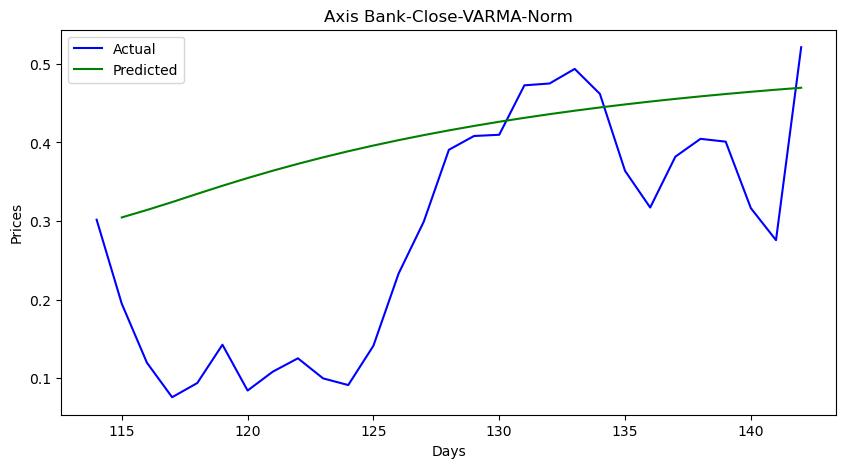

In [12]:
from stockFunctions import graph
graph(y_test["Close"],pred["Close"],"Actual","Predicted","Axis Bank-Close-VARMA-Norm","Days","Prices")

In [13]:
forecast = result.predict(start=len(data1), end=len(data1) + 3, exog=X_test[:4])
forecast

,Close,High,Open,Low
143,0.471934,0.424634,0.476928,0.489503
144,0.474126,0.426844,0.479179,0.491865
145,0.476184,0.428920,0.481292,0.494083
146,0.478116,0.430868,0.483276,0.496165
